# The Machine Learning Group Challenge!

##  Today's Mission
- Your objective is to devise the best possible model to predict successful/default loans using a preprocessed version of the Lending Club loan dataset.

- Class into divided into 2 groups.

- The training data is 13689 loans labeled either as 1 (successful) or 0 (default). Comes with 30 categorical and numerical features. The testing data is also 13689 loans.

- A data dictionary file is included as well. It is a table explaining each what each feature means.

- Groups will judged on how much money their model makes. You will evaluate your model on the testing dataset. You cannot used testing data to train a model.

- Your profit will be determined by the amount of money you make from correctly predicting good loans (loan amount * interest rate/100.) subtracted by the money you lose from incorrectly predicting bad loans as good (-loan amount). I have given a function to calculate that.

- Finding the correct probability threshold will be super key in determing how much money you make.

- **VERY IMPORTANT:** You must transform your testing the data the same way you did your training data. So make sure you have the same columns in the same order.
        
- Stewart and I will be on be hand for guidance. However I want you to primarily use your teammates for help. 

- Use all the tools at your disposal, try all the models we've learned in class. Refer to past class notebooks for help. Be sure to use modeling evaluating techniques such as ROC curves, confusion matrix, recall/precision, etc.

- I recommend starting off simple by using a small number of features

- To optimize model, find the right combination of features and the right model with the right parameters. Get creative!

- Remember to use your time wisely, it will go by fast. Communicate amongst yourselves often.
   

### Online resources on Lending Club loan data
Kaggle Page: https://www.kaggle.com/wendykan/lending-club-loan-data. Make sure to check out the kernels section.

Y Hat tutorial (It's in R, but its still useful): http://blog.yhat.com/posts/machine-learning-for-predicting-bad-loans.html

Blog tutorial on the data from Kevin Davenport: http://kldavenport.com/lending-club-data-analysis-revisted-with-python/



### Class Time
No class breaks. But individual breaks are allowed of course.

- 6:30 - 7:00
    - Feature engineering/selection: make dummy variables, dropping features, scaling, and other methods of transforming data. 
    - Exploratory data analysis aka get to know your features time.
    
    
- 7:00 - 8:45
    - Modeling time!!
    
    
- 8:45 - 9:25
    - Model testing.
    
    
- 9:25 - 9:30
    - Winner decision. Exit tickets.

In [1]:
#Imports and set pandas options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
pd.set_option("max.columns", 100)
pd.set_option("max.colwidth", 100)

In [2]:
# Load in training data.
# Loan_status column is the target variable. Remember to drop it from df.
train = pd.read_csv("../../data/lending_club/challenge_training_data.csv")
train.head(2)

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,acc_now_delinq,delinq_amnt,tax_liens
0,742238,3150.0,3150.0,36 months,10.99%,103.12,B,A-1 Casino Rd Mini Storage,9 years,RENT,15300.0,Verified,1,Borrower added on 05/02/11 > I plan to use these funds to pay off a higher rate credit card.<b...,debt_consolidation,lowerinterest,19.76,0.0,695.0,699.0,0.0,5.0,0.0,9316.0,76.4%,9.0,Feb-2014,0.0,0.0,0.0
1,567423,10000.0,10000.0,36 months,7.51%,311.11,A,ORION MECHANICAL INC.,4 years,OWN,125000.0,Not Verified,1,Borrower added on 08/19/10 > CONSOLIDATE OUT STANDING CREDIT CARD LOANS AND PURCHASES FOR NEW ...,debt_consolidation,CONSOLIDATE,18.43,0.0,800.0,804.0,1.0,16.0,0.0,25364.0,2.9%,40.0,Feb-2017,0.0,0.0,0.0


In [3]:
#Load in data dictionary
data_dict = pd.read_csv("../../data/lending_club/the_data_dictionary.csv")
data_dict.head()

,dtypes,name,description
0,float64,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit ..."
1,object,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
2,float64,installment,The monthly payment owed by the borrower if the loan originates.
3,object,grade,LC assigned loan grade
4,object,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one yea...


In [4]:
#Load in test data when you're ready 
# test = pd.read_csv("../../data/lending_club/challenge_testing_data.csv")


Here is the threshold function. Input your probabilities for class 1 and set a probability threshold of your choice. The default threshold is 0.5. The output will be 1's and 0s, 1 values for all the values that are greater or equal to your predetermined threshold value.

In [5]:

def threshold(probs, thres = 0.5):
    output = np.where(probs >= thres, 1, 0)
    return output

This is the profit function. It takes in a dataframe with the loan_amnt, int_rate, target variable, and class predictions values.

- It first checks to see if a row has 0 in the outcome column and 1 in the predicted (false positive) and returns the negative value of the loan_amnt. This is how much money you lost for loans that mean that condition.

- Then it checks for true positives, meaning conditions where both the target and predicted values equal 1, then return the loan_amnt times the int_rate divided by 100. This is how much money you made from loans that meet this condition.

- Everything else gets a zero.

In [6]:
def profit_function(data):
    if data.target == 0 and data.predicted == 1:
        return -1 *data.loan_amnt
    elif data.target == 1 and data.predicted == 1:
        return data.loan_amnt * (data.int_rate/100.)
    else:
        return 0

Here's an example of using the threshold and profit_functions

In [7]:
#List of probabilities
probs = np.array([0.2, 0.5, 0.8, 0.9, 0.1, 0.75])

#Pass in probabilities into threshold function, using .7 as threshold
preds = threshold(probs, thres=.7)
preds

array([0, 0, 1, 1, 0, 1])

In [8]:
sample_df = {"loan_amnt": [1000, 500, 200, 5000, 3000, 6000],
            "int_rate": [18, 20, 4, 5, 2, 10], 
            "target": [0, 1, 0, 1, 0, 1]}

#Put dictionary in data frame

profit_df = pd.DataFrame(sample_df)

profit_df

,int_rate,loan_amnt,target
0,18,1000,0
1,20,500,1
2,4,200,0
3,5,5000,1
4,2,3000,0
5,10,6000,1


In [9]:
#Add in predictions

profit_df["predicted"] = preds
profit_df

,int_rate,loan_amnt,target,predicted
0,18,1000,0,0
1,20,500,1,0
2,4,200,0,1
3,5,5000,1,1
4,2,3000,0,0
5,10,6000,1,1


In [10]:
#Apply function onto data frame
profit_series = profit_df.apply(profit_function, axis = 1)
profit_series

0      0.0
1      0.0
2   -200.0
3    250.0
4      0.0
5    600.0
dtype: float64

In [11]:
#Sum up profits and losses
profit_series.sum()

650.0

In [7]:
#List of probabilities
probs = np.array([0.2, 0.5, 0.8, 0.9, 0.1, 0.75])

#Pass in probabilities into threshold function, using .7 as threshold
preds = threshold(probs, thres=.7)
preds

array([0, 0, 1, 1, 0, 1])

In [8]:
sample_df = {"loan_amnt": [1000, 500, 200, 5000, 3000, 6000],
            "int_rate": [18, 20, 4, 5, 2, 10], 
            "target": [0, 1, 0, 1, 0, 1]}

#Put dictionary in data frame

profit_df = pd.DataFrame(sample_df)

profit_df

,int_rate,loan_amnt,target
0,18,1000,0
1,20,500,1
2,4,200,0
3,5,5000,1
4,2,3000,0
5,10,6000,1


In [9]:
#Add in predictions

profit_df["predicted"] = preds
profit_df

,int_rate,loan_amnt,target,predicted
0,18,1000,0,0
1,20,500,1,0
2,4,200,0,1
3,5,5000,1,1
4,2,3000,0,0
5,10,6000,1,1


In [10]:
#Apply function onto data frame
profit_series = profit_df.apply(profit_function, axis = 1)
profit_series

0      0.0
1      0.0
2   -200.0
3    250.0
4      0.0
5    600.0
dtype: float64

In [11]:
#Sum up profits and losses
profit_series.sum()

650.0

This model made $650

## Let the games begin!!

In [164]:
train_orig = pd.read_csv("../../data/lending_club/challenge_training_data.csv")
train = train_orig.copy()
train.head(2)

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,acc_now_delinq,delinq_amnt,tax_liens
0,742238,3150.0,3150.0,36 months,10.99%,103.12,B,A-1 Casino Rd Mini Storage,9 years,RENT,15300.0,Verified,1,Borrower added on 05/02/11 > I plan to use these funds to pay off a higher rate credit card.<b...,debt_consolidation,lowerinterest,19.76,0.0,695.0,699.0,0.0,5.0,0.0,9316.0,76.4%,9.0,Feb-2014,0.0,0.0,0.0
1,567423,10000.0,10000.0,36 months,7.51%,311.11,A,ORION MECHANICAL INC.,4 years,OWN,125000.0,Not Verified,1,Borrower added on 08/19/10 > CONSOLIDATE OUT STANDING CREDIT CARD LOANS AND PURCHASES FOR NEW ...,debt_consolidation,CONSOLIDATE,18.43,0.0,800.0,804.0,1.0,16.0,0.0,25364.0,2.9%,40.0,Feb-2017,0.0,0.0,0.0


In [165]:
data_dict = pd.read_csv("../../data/lending_club/the_data_dictionary.csv")
data_dict



,dtypes,name,description
0,float64,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit ..."
1,object,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
2,float64,installment,The monthly payment owed by the borrower if the loan originates.
3,object,grade,LC assigned loan grade
4,object,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one yea...
5,object,home_ownership,The home ownership status provided by the borrower during registration or obtained from the cred...
6,float64,annual_inc,The self-reported annual income provided by the borrower during registration.
7,object,verification_status,"Indicates if income was verified by LC, not verified, or if the income source was verified"
8,object,loan_status,Current status of the loan
9,object,purpose,A category provided by the borrower for the loan request.


In [166]:
train.corr()

,id,loan_amnt,funded_amnt,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,delinq_amnt,tax_liens
id,1.000000,0.200422,0.207619,0.110181,0.025484,0.172884,0.081509,-0.044254,0.112211,0.112211,-0.210223,0.015206,-0.032031,-0.049540,0.059740,NaN,NaN,-0.019617
loan_amnt,0.200422,1.000000,0.979824,0.926593,0.302584,0.013136,0.073157,-0.034562,0.128810,0.128810,-0.053090,0.169631,-0.048453,0.254794,0.259847,NaN,NaN,-0.011027
funded_amnt,0.207619,0.979824,1.000000,0.954544,0.300004,0.014521,0.074090,-0.037667,0.120513,0.120513,-0.053264,0.167923,-0.049016,0.253378,0.254285,NaN,NaN,-0.011076
installment,0.110181,0.926593,0.954544,1.000000,0.310228,0.009810,0.065028,-0.025896,0.054176,0.054176,-0.029958,0.169073,-0.043203,0.275574,0.239929,NaN,NaN,-0.010941
annual_inc,0.025484,0.302584,0.300004,0.310228,1.000000,0.032233,-0.121657,0.031826,0.045770,0.045770,0.026730,0.202448,-0.015188,0.339139,0.290302,NaN,NaN,-0.003662
loan_status,0.172884,0.013136,0.014521,0.009810,0.032233,1.000000,-0.046280,-0.035297,0.238120,0.238120,-0.371061,-0.019613,-0.080022,-0.103399,0.007716,NaN,NaN,-0.016687
dti,0.081509,0.073157,0.074090,0.065028,-0.121657,-0.046280,1.000000,-0.035435,-0.189935,-0.189935,0.004994,0.297160,-0.005538,0.206351,0.241738,NaN,NaN,-0.006007
delinq_2yrs,-0.044254,-0.034562,-0.037667,-0.025896,0.031826,-0.035297,-0.035435,1.000000,-0.220971,-0.220971,0.022363,0.018300,0.017498,-0.047559,0.067307,NaN,NaN,-0.002584
fico_range_low,0.112211,0.128810,0.120513,0.054176,0.045770,0.238120,-0.189935,-0.220971,1.000000,1.000000,-0.149492,-0.028387,-0.161982,-0.035749,0.105756,NaN,NaN,-0.016053
fico_range_high,0.112211,0.128810,0.120513,0.054176,0.045770,0.238120,-0.189935,-0.220971,1.000000,1.000000,-0.149492,-0.028387,-0.161982,-0.035749,0.105756,NaN,NaN,-0.016053


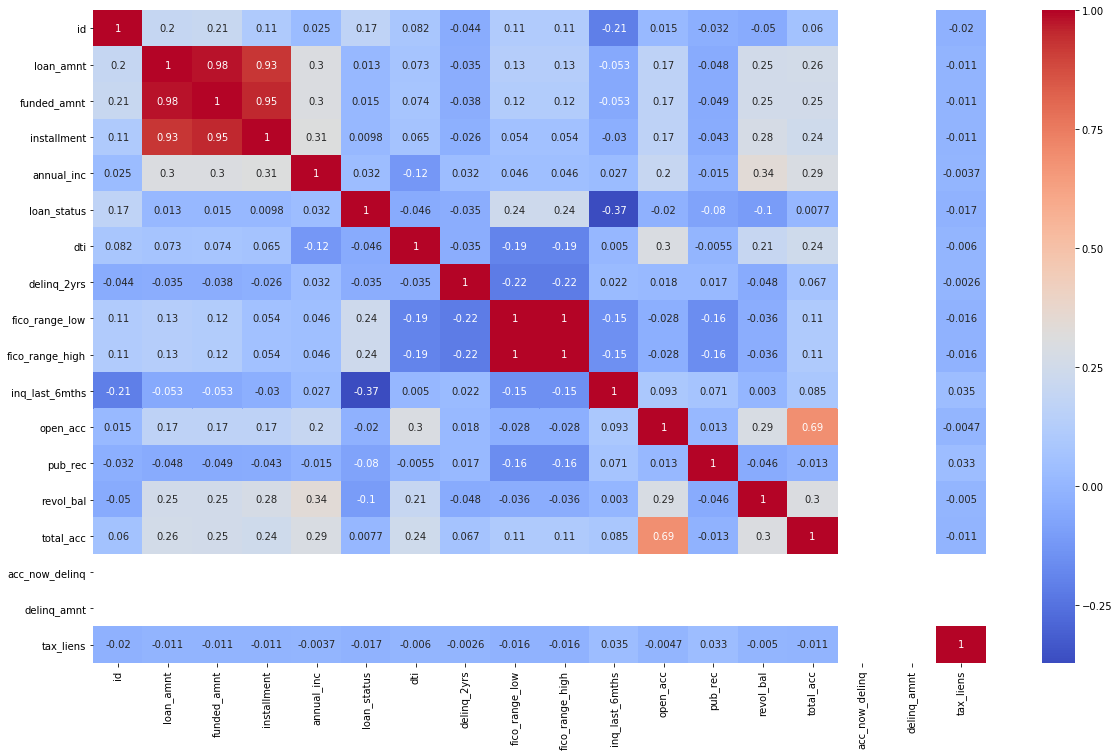

In [167]:
plt.figure(figsize=(20,12))
sb.heatmap(train.corr(), annot=True, cmap='coolwarm')

In [168]:
# cols = ["loan_amnt","term","int_rate","grade","emp_length","home_ownership","annual_inc","purpose","dti","delinq_2yrs","fico_range_low","fico_range_high","inq_last_6mths","open_acc","revol_bal","total_acc"]
# train = train[cols]

In [169]:
train.shape


(13689, 30)

In [170]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13689 entries, 0 to 13688
Data columns (total 30 columns):
id                     13689 non-null int64
loan_amnt              13689 non-null float64
funded_amnt            13689 non-null float64
term                   13689 non-null object
int_rate               13689 non-null object
installment            13689 non-null float64
grade                  13689 non-null object
emp_title              13687 non-null object
emp_length             13666 non-null object
home_ownership         13689 non-null object
annual_inc             13689 non-null float64
verification_status    13689 non-null object
loan_status            13689 non-null int64
desc                   13689 non-null object
purpose                13689 non-null object
title                  13689 non-null object
dti                    13689 non-null float64
delinq_2yrs            13689 non-null float64
fico_range_low         13689 non-null float64
fico_range_high        13689 no

In [171]:
train.dropna(inplace=True)

train.drop_duplicates(inplace=True)

In [172]:
train['fico_avg']= (train2.fico_range_low +train2.fico_range_low)/2
train.drop(['fico_range_low','fico_range_low'], axis=1, inplace=True)

In [173]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13665 entries, 0 to 13688
Data columns (total 30 columns):
id                     13665 non-null int64
loan_amnt              13665 non-null float64
funded_amnt            13665 non-null float64
term                   13665 non-null object
int_rate               13665 non-null object
installment            13665 non-null float64
grade                  13665 non-null object
emp_title              13665 non-null object
emp_length             13665 non-null object
home_ownership         13665 non-null object
annual_inc             13665 non-null float64
verification_status    13665 non-null object
loan_status            13665 non-null int64
desc                   13665 non-null object
purpose                13665 non-null object
title                  13665 non-null object
dti                    13665 non-null float64
delinq_2yrs            13665 non-null float64
fico_range_high        13665 non-null float64
inq_last_6mths         13665 no

In [174]:
train.head(2)

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,acc_now_delinq,delinq_amnt,tax_liens,fico_avg
0,742238,3150.0,3150.0,36 months,10.99%,103.12,B,A-1 Casino Rd Mini Storage,9 years,RENT,15300.0,Verified,1,Borrower added on 05/02/11 > I plan to use these funds to pay off a higher rate credit card.<b...,debt_consolidation,lowerinterest,19.76,0.0,699.0,0.0,5.0,0.0,9316.0,76.4%,9.0,Feb-2014,0.0,0.0,0.0,695.0
1,567423,10000.0,10000.0,36 months,7.51%,311.11,A,ORION MECHANICAL INC.,4 years,OWN,125000.0,Not Verified,1,Borrower added on 08/19/10 > CONSOLIDATE OUT STANDING CREDIT CARD LOANS AND PURCHASES FOR NEW ...,debt_consolidation,CONSOLIDATE,18.43,0.0,804.0,1.0,16.0,0.0,25364.0,2.9%,40.0,Feb-2017,0.0,0.0,0.0,800.0


In [175]:
# train.term = train.term.str.replace(' months', '').replace(' ', '')

In [176]:
# train.int_rate = train.int_rate.replace("%", "").replace(' ', '').astype('float64')

In [177]:
# train.int_rate.replace('%', '')

In [178]:
train["term"] = train.term.str.replace("months", "")

train["int_rate"] = train.int_rate.str.replace("%", "")

train["emp_length"] = train.emp_length.str.replace("years", "")

train["home_ownership"] = train.emp_length.str.replace("rent", "1")

train["home_ownership"] = train.emp_length.str.replace("own", "0")

train["verification_status"] = train.emp_length.str.replace("Not Verified", "0")

train["verification_status"] = train.emp_length.str.replace("Verified", "1")

train["verification_status"] = train.emp_length.str.replace("Source Verified", "1")

train["revol_util"] = train.revol_util.str.replace("%", "")

In [179]:
# train["term"] = train.term.str.replace("months", "")

# train["int_rate"] = train.int_rate.str.replace("%", "")

# train["emp_length"] = train.emp_length.str.replace("years", "")

# train["emp_length"] = train.emp_length.str.replace("year", "")

# train["emp_length"] = train.emp_length.str.replace("+", "")

# train["emp_length"] = train.emp_length.str.replace("<", "")

# train["emp_length"] = train.emp_length.str.replace("n/a", "")

# train["home_ownership"] = train.emp_length.str.replace("rent", "1")

# train["home_ownership"] = train.emp_length.str.replace("own", "0")

# train["verification_status"] = train.emp_length.str.replace("Not Verified", "0")

# train["verification_status"] = train.emp_length.str.replace("Verified", "1")

# train["verification_status"] = train.emp_length.str.replace("Source Verified", "1")

In [180]:
train.term = train.term.astype(float)
train.int_rate = train.int_rate.astype(float)
# train.emp_length = train.emp_length.astype(float)

In [181]:
train.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,acc_now_delinq,delinq_amnt,tax_liens,fico_avg
0,742238,3150.0,3150.0,36.0,10.99,103.12,B,A-1 Casino Rd Mini Storage,9,9,15300.0,9,1,Borrower added on 05/02/11 > I plan to use these funds to pay off a higher rate credit card.<b...,debt_consolidation,lowerinterest,19.76,0.0,699.0,0.0,5.0,0.0,9316.0,76.4,9.0,Feb-2014,0.0,0.0,0.0,695.0
1,567423,10000.0,10000.0,36.0,7.51,311.11,A,ORION MECHANICAL INC.,4,4,125000.0,4,1,Borrower added on 08/19/10 > CONSOLIDATE OUT STANDING CREDIT CARD LOANS AND PURCHASES FOR NEW ...,debt_consolidation,CONSOLIDATE,18.43,0.0,804.0,1.0,16.0,0.0,25364.0,2.9,40.0,Feb-2017,0.0,0.0,0.0,800.0
2,457181,11000.0,11000.0,36.0,12.53,368.13,B,"U.S. Government, Dept of Homeland Securi",3,3,81600.0,3,1,"568147 added on 11/04/09 > Personal Loan, Deposited to TD nov 04 2009<br/> 568147 added on 11/...",other,Personal Loan 11/2009,5.12,0.0,729.0,2.0,5.0,0.0,358.0,7.5,10.0,Feb-2017,0.0,0.0,0.0,725.0
3,872939,2200.0,2200.0,36.0,13.49,74.65,C,Boeing,5,5,80000.0,5,1,"I'll use this to finish paying off my credit cards. I do make $80k a year, so I expect that I'll...",debt_consolidation,LendingClubLoan,3.27,0.0,704.0,0.0,2.0,0.0,10142.0,95.7,6.0,Sep-2011,0.0,0.0,0.0,700.0
4,448219,4500.0,4500.0,36.0,13.22,152.11,C,Charles Wright Academy,4,4,30555.0,4,1,"I am a single mother to a wonderful 7 year old girl. We have had our share of difficulties, most...",debt_consolidation,"Medical, Consolidation, & Kauai, Oh My!",4.32,0.0,694.0,1.0,4.0,1.0,3371.0,88.7,14.0,Feb-2017,0.0,0.0,0.0,690.0


In [182]:
train.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,acc_now_delinq,delinq_amnt,tax_liens,fico_avg
0,742238,3150.0,3150.0,36.0,10.99,103.12,B,A-1 Casino Rd Mini Storage,9,9,15300.0,9,1,Borrower added on 05/02/11 > I plan to use these funds to pay off a higher rate credit card.<b...,debt_consolidation,lowerinterest,19.76,0.0,699.0,0.0,5.0,0.0,9316.0,76.4,9.0,Feb-2014,0.0,0.0,0.0,695.0
1,567423,10000.0,10000.0,36.0,7.51,311.11,A,ORION MECHANICAL INC.,4,4,125000.0,4,1,Borrower added on 08/19/10 > CONSOLIDATE OUT STANDING CREDIT CARD LOANS AND PURCHASES FOR NEW ...,debt_consolidation,CONSOLIDATE,18.43,0.0,804.0,1.0,16.0,0.0,25364.0,2.9,40.0,Feb-2017,0.0,0.0,0.0,800.0
2,457181,11000.0,11000.0,36.0,12.53,368.13,B,"U.S. Government, Dept of Homeland Securi",3,3,81600.0,3,1,"568147 added on 11/04/09 > Personal Loan, Deposited to TD nov 04 2009<br/> 568147 added on 11/...",other,Personal Loan 11/2009,5.12,0.0,729.0,2.0,5.0,0.0,358.0,7.5,10.0,Feb-2017,0.0,0.0,0.0,725.0
3,872939,2200.0,2200.0,36.0,13.49,74.65,C,Boeing,5,5,80000.0,5,1,"I'll use this to finish paying off my credit cards. I do make $80k a year, so I expect that I'll...",debt_consolidation,LendingClubLoan,3.27,0.0,704.0,0.0,2.0,0.0,10142.0,95.7,6.0,Sep-2011,0.0,0.0,0.0,700.0
4,448219,4500.0,4500.0,36.0,13.22,152.11,C,Charles Wright Academy,4,4,30555.0,4,1,"I am a single mother to a wonderful 7 year old girl. We have had our share of difficulties, most...",debt_consolidation,"Medical, Consolidation, & Kauai, Oh My!",4.32,0.0,694.0,1.0,4.0,1.0,3371.0,88.7,14.0,Feb-2017,0.0,0.0,0.0,690.0


In [105]:
from sklearn.linear_model import LogisticRegression

In [190]:
X.head()

,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,fico_avg,inq_last_6mths,open_acc,revol_bal,total_acc
0,3150.0,36.0,10.99,15300.0,19.76,0.0,695.0,0.0,5.0,9316.0,9.0
1,10000.0,36.0,7.51,125000.0,18.43,0.0,800.0,1.0,16.0,25364.0,40.0
2,11000.0,36.0,12.53,81600.0,5.12,0.0,725.0,2.0,5.0,358.0,10.0
3,2200.0,36.0,13.49,80000.0,3.27,0.0,700.0,0.0,2.0,10142.0,6.0
4,4500.0,36.0,13.22,30555.0,4.32,0.0,690.0,1.0,4.0,3371.0,14.0


In [191]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13665 entries, 0 to 13688
Data columns (total 11 columns):
loan_amnt         13665 non-null float64
term              13665 non-null float64
int_rate          13665 non-null float64
annual_inc        13665 non-null float64
dti               13665 non-null float64
delinq_2yrs       13665 non-null float64
fico_avg          13665 non-null float64
inq_last_6mths    13665 non-null float64
open_acc          13665 non-null float64
revol_bal         13665 non-null float64
total_acc         13665 non-null float64
dtypes: float64(11)
memory usage: 1.3 MB


In [210]:
cols = ["loan_amnt","term","int_rate","annual_inc","dti","delinq_2yrs","fico_avg","inq_last_6mths","open_acc","revol_bal","total_acc"]

X = train[cols]
y = train.loan_status

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8421286031042129

In [ ]:
# lr.f

In [206]:
# train.corr().sort_values(by='loan_status', ascending = False).head(5)

,id,loan_amnt,funded_amnt,term,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,delinq_amnt,tax_liens,fico_avg
loan_status,0.172668,0.012724,0.014018,-0.055590,-0.248045,0.009473,0.031976,1.000000,-0.045458,-0.035854,0.237814,-0.371535,-0.019658,-0.079367,-0.103479,0.007782,NaN,NaN,-0.016713,0.237814
fico_avg,0.111984,0.129158,0.120786,0.016422,-0.697544,0.054542,0.045849,0.237814,-0.190182,-0.221057,1.000000,-0.149609,-0.028065,-0.161859,-0.035582,0.105742,NaN,NaN,-0.016072,1.000000
fico_range_high,0.111984,0.129158,0.120786,0.016422,-0.697544,0.054542,0.045849,0.237814,-0.190182,-0.221057,1.000000,-0.149609,-0.028065,-0.161859,-0.035582,0.105742,NaN,NaN,-0.016072,1.000000
id,1.000000,0.200383,0.207535,0.326691,0.019804,0.110111,0.025522,0.172668,0.081585,-0.044056,0.111984,-0.210225,0.015044,-0.032313,-0.049311,0.059806,NaN,NaN,-0.019624,0.111984
annual_inc,0.025522,0.302251,0.299659,0.032726,0.065187,0.309834,1.000000,0.031976,-0.121895,0.032069,0.045849,0.026509,0.202105,-0.015263,0.338989,0.289969,NaN,NaN,-0.003669,0.045849


In [214]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [216]:
cross_val_score(LogisticRegression(), X, y, scoring='precision', cv=5).mean()

0.8250170783697112

In [241]:
cross_val_score(DecisionTreeClassifier(), X, y, scoring='precision', cv=5).mean()

0.8635745141022066

In [218]:
cross_val_score(KNeighborsClassifier(), X, y, scoring='precision', cv=5).mean()

0.7983179252149721

In [233]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [221]:
# trying now with 500 . estimatores since this is usually effective in icnreasing model accuracy....
rfreg_gmv_tuned = RandomForestClassifier(n_estimators=300,random_state=1)

rfreg_gmv_tuned.fit(X, y)

cv = cross_val_score(rfreg_gmv_tuned, X, y, scoring='precision', cv=5)
cv.mean()

0.8594713752018972

In [223]:
X.shape

(13665, 11)

In [230]:
# estimator_range = range(200, 510, 50)
# features_range = range(1, 11, 2)
depth_range = range(2, 12)

param_grid_rf = {}
# param_grid_rf["n_estimators"] = list(estimator_range)
# param_grid_rf["max_features"] = list(features_range)
param_grid_rf["max_depth"] = list(depth_range)


rand_grid_rf_2 = RandomizedSearchCV(estimator = RandomForestClassifier(), n_iter =10,
                       param_distributions = param_grid_rf, cv = 5, scoring='precision')


#fit rand search
rand_grid_rf_2.fit(X, y)

rand_grid_rf_2.best_params_

{'max_depth': 11}

In [231]:
rand_grid_rf_2.best_score_

0.8574398370866647

In [234]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [235]:
pca.fit_transform(X)

array([[-5.50386661e+04,  2.33152887e+03,  6.21436637e+03,
        -1.16627071e+01],
       [ 5.60096156e+04,  1.75813461e+03,  3.66435358e+03,
         8.91746947e+01],
       [ 9.40380924e+03, -1.62170086e+04, -1.63552216e+02,
         1.07216129e+01],
       ...,
       [ 1.04497343e+04,  3.00376390e+01, -5.03133387e+03,
        -6.16258031e+00],
       [-8.68296009e+03,  1.04628739e+04,  4.62317819e+03,
        -2.65337365e+00],
       [-3.74321246e+04,  2.65992710e+03, -4.95546623e+03,
         4.50696131e+01]])

In [236]:
pca.components_

array([[ 3.90623274e-02,  6.01149166e-06,  4.33768882e-06,
         9.87760827e-01, -1.22919617e-05,  2.42433271e-07,
         2.65439499e-05,  7.31171176e-07,  1.65003890e-05,
         1.51005561e-01,  5.96872286e-05],
       [ 5.55543599e-02, -6.43097269e-07,  1.32939907e-05,
        -1.53033961e-01,  8.65864319e-05, -1.52426437e-06,
        -9.24807793e-05, -7.17761147e-07,  4.68861108e-05,
         9.86658142e-01,  1.11049850e-04],
       [-9.97690821e-01, -5.50623689e-04, -1.44961447e-04,
         3.01521740e-02, -6.63088782e-05,  2.58125490e-06,
        -7.00122425e-04,  1.55674702e-05, -4.64982998e-05,
         6.08522348e-02, -2.39052636e-04],
       [-6.79338276e-04, -1.12503080e-02, -7.52948499e-02,
        -2.14287946e-05, -3.51539806e-02, -3.12409267e-03,
         9.95989371e-01, -6.72327608e-03, -3.95615588e-03,
         1.29171701e-04,  3.00398860e-02]])

In [277]:
dt = DecisionTreeClassifier(max_depth = 11)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)
preds = dt.predict(X_test)
metrics.precision_score(y_test, preds)

0.8603904126513466

In [272]:
depths = list(range(15))

scs = []

for d in depths
    dt = DecisionTreeClassifier(max_depth = d)
    scs.append(cross_val_score(dt, X, y, cv=5, scoring='precision').mean())
    
plt.plot()

0.8592017738359202

0.8600048863913999

In [262]:
finalp =  dt.predict_proba(X_test)
finalp

array([[0.29005059, 0.70994941],
       [0.08517609, 0.91482391],
       [0.29005059, 0.70994941],
       ...,
       [0.14774115, 0.85225885],
       [0.21311475, 0.78688525],
       [0.08517609, 0.91482391]])

In [265]:
# finalp[:100, :]

In [266]:
threshold(finalp, thres=0.7)

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
profit_function()

In [278]:
def profit_function(data):
   if data.loan_status == 0 and data.predicted == 1:
       return -1 *data.loan_amnt
   elif data.loan_status == 1 and data.predicted == 1:
       return data.loan_amnt * (data.int_rate/100.)
   else:
       return 0

In [284]:
df = pd.read_csv('../../data/df_send.csv')

df.columns

Index(['loan_amnt', 'int_rate', 'loan_status', 'model_scored'], dtype='object')

In [286]:
# List of probabilities
# probs = np.array([0.2, 0.5, 0.8, 0.9, 0.1, 0.75])

#Pass in probabilities into threshold function, using .7 as threshold
preds = threshold(df.model_scored, thres=.7)
preds

array([1, 1, 1, ..., 0, 0, 0])

In [287]:

profit_df = pd.DataFrame(df)

# profit_df

In [291]:
#Add in predictions

profit_df["predicted"] = preds
# profit_df

In [292]:
#Apply function onto data frame
profit_series = profit_df.apply(profit_function, axis = 1)
# profit_series

In [290]:
#Sum up profits and losses
profit_series.sum()

-6835779.3125

In [302]:
thresh = range(10)
t = .9290

for x in thresh:
    preds = threshold(df.model_scored, thres=t)
    profit_df["predicted"] = preds
    profit_series = profit_df.apply(profit_function, axis = 1)
    print(str(t)+":   "+str(profit_series.sum()))
    t=t+.0001


0.929:   601918.3675
0.9291:   628469.9175000001
0.9292:   622405.9025000001
0.9293:   641365.3225
0.9294:   676458.0825
0.9295:   668315.0925
0.9296:   666971.3325
0.9297:   683091.6325000001
0.9298:   681160.5325
0.9299:   679302.0825
